In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


In [2]:
data_feature = pd.read_csv('df_features.csv')
print(data_feature.shape)
data_feature.head()

(40540, 98)


file_name  signal_mean  signal_std  signal_skew  \
0     38359_Rock_music.wav        0.291       0.350        0.553   
1     50194_Rock_music.wav        0.222       0.278        0.990   
2  24275_Hip_hop_music.wav        0.174       0.232        1.326   
3      43654_Pop_music.wav        0.306       0.373        0.607   
4     41609_Rock_music.wav        0.237       0.298        1.004   

   signal_kurtosis  zcr_mean  zcr_std  rmse_mean  rmse_std    tempo  ...  \
0           -0.679     0.261    0.050      0.349     0.030  107.666  ...   
1           -0.015     0.134    0.027      0.276     0.030  135.999  ...   
2            0.876     0.253    0.061      0.223     0.065  143.555  ...   
3           -0.578     0.084    0.043      0.370     0.051  123.047  ...   
4            0.021     0.165    0.062      0.294     0.047  123.047  ...   

   chroma_stft_3_std  chroma_stft_4_std  chroma_stft_5_std  chroma_stft_6_std  \
0              0.280              0.229              0.221              0.316   
1              0.252              0.294              0.337              0.289   
2              0.333              0.333              0.229              0.153   
3              0.209              0.216              0.260              0.322   
4              0.255              0.186              0.274              0.241   

   chroma_stft_7_std  chroma_stft_8_std  chroma_stft_9_std  \
0              0.195              0.256              0.248   
1              0.281              0.217              0.257   
2              0.155              0.252              0.273   
3              0.299              0.264              0.193   
4              0.222              0.181              0.246   

   chroma_stft_10_std  chroma_stft_11_std  chroma_stft_12_std  
0               0.268               0.256               0.251  
1               0.216               0.286               0.285  
2               0.283               0.306               0.303  
3               0.306               0.272               0.234  
4               0.315               0.170               0.276  

[5 rows x 98 columns]

In [3]:
label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

# Normalization of the features
scalar = MinMaxScaler()
data_feature[data_feature.columns[1:]] = scalar.fit_transform(data_feature[data_feature.columns[1:]])
data_feature['label'] = data_feature['file_name'].apply(lambda x: label_dict[x[:-4].split('_')[1]])
data_feature.head()


file_name  signal_mean  signal_std  signal_skew  \
0     38359_Rock_music.wav     0.313240    0.370763     0.140444   
1     50194_Rock_music.wav     0.238967    0.294492     0.155385   
2  24275_Hip_hop_music.wav     0.187298    0.245763     0.166872   
3      43654_Pop_music.wav     0.329386    0.395127     0.142291   
4     41609_Rock_music.wav     0.255113    0.315678     0.155863   

   signal_kurtosis  zcr_mean   zcr_std  rmse_mean  rmse_std     tempo  ...  \
0         0.002384  0.426471  0.190840   0.370488  0.089820  0.322914  ...   
1         0.003066  0.218954  0.103053   0.292994  0.089820  0.473681  ...   
2         0.003982  0.413399  0.232824   0.236730  0.194611  0.513888  ...   
3         0.002488  0.137255  0.164122   0.392781  0.152695  0.404760  ...   
4         0.003103  0.269608  0.236641   0.312102  0.140719  0.404760  ...   

   chroma_stft_4_std  chroma_stft_5_std  chroma_stft_6_std  chroma_stft_7_std  \
0           0.477083           0.463312           0.691466           0.407098   
1           0.612500           0.706499           0.632385           0.586639   
2           0.693750           0.480084           0.334792           0.323591   
3           0.450000           0.545073           0.704595           0.624217   
4           0.387500           0.574423           0.527352           0.463466   

   chroma_stft_8_std  chroma_stft_9_std  chroma_stft_10_std  \
0           0.535565           0.513458            0.557173   
1           0.453975           0.532091            0.449064   
2           0.527197           0.565217            0.588358   
3           0.552301           0.399586            0.636175   
4           0.378661           0.509317            0.654886   

   chroma_stft_11_std  chroma_stft_12_std  label  
0            0.556522            0.548035      5  
1            0.621739            0.622271      5  
2            0.665217            0.661572      0  
3            0.591304            0.510917      1  
4            0.369565            0.602620      5  

[5 rows x 99 columns]

In [4]:
  # Train-test split of files 
with open('testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(data_feature[data_feature.file_name==t].index[0])
    
data_feature_test = data_feature.iloc[indices,:]
data_feature.drop(labels=indices, inplace=True)


x_train = data_feature[data_feature.columns[1:-1]]
x_test = data_feature_test[data_feature.columns[1:-1]]
y_train = data_feature['label']
y_test = data_feature_test['label']

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

[08:26:40] WARNING: ../src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Test Set Accuracy =  0.59
Test Set F-score =  0.54
Confusion matrix, without normalization
[[237  51  11  11  15  10  29]
 [ 44 217  18  17   7  56  24]
 [ 14  19 106   1   3  16  12]
 [ 49  60   5  43  16  26  33]
 [ 30  25   4  14  45   6   8]
 [  7  46   9   4   4 329  17]
 [ 23  30   9   9   5  43 210]]
CPU times: user 43min 52s, sys: 6.2 s, total: 43min 58s
Wall time: 6min 1s


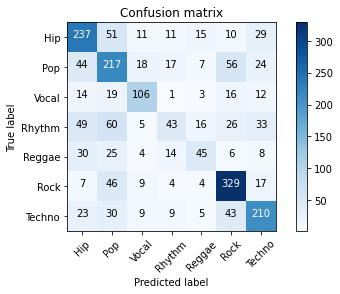

In [6]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)
